In [1]:
from hydra import compose, initialize
from pathlib import Path
from chemprop import data, featurizers, models
from chemprop.nn.message_passing import BondMessagePassing
import torch
from torch.utils.data import DataLoader
import lightning as L
import pandas as pd
import numpy as np
from ergochemics.mapping import rc_to_nest
from rdkit import Chem
from cgr.ml import collate_batch, sep_aidx_to_bin_label, GNN, LinearPredictor
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, accuracy_score
import matplotlib.pyplot as plt

with initialize(version_base=None, config_path="../configs/filepaths"):
    filepaths = compose(config_name="filepaths")


In [2]:
df = pd.read_parquet(
    Path(filepaths.raw_data) / "mapped_sprhea_240310_v3_mapped_no_subunits_x_mechanistic_rules.parquet"
)
df["reaction_center"] = df["reaction_center"].apply(rc_to_nest)
smis = df["am_smarts"].tolist()
df["binary_label"] = df.apply(lambda x: sep_aidx_to_bin_label(x.am_smarts, x.reaction_center), axis=1) # Convert aidxs to binary labels for block mol
df.head()

,rxn_id,smarts,am_smarts,rule,reaction_center,rule_id,binary_label
0,1,CC(O)C(O)C(O)C(O)C(=O)O>>O.CC(O)C(O)CC(=O)C(=O)O,[CH3:11][CH:9]([OH:12])[CH:8]([OH:10])[CH:7]([...,[O&D1&v2&H0&0*&!R:1]=[C&D3&v4&H0&0*&!R&z2:2](-...,"(((10, 9, 11, 7, 8, 5, 6),), ((0,), (0, 1, 2, ...",841,"([[0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1..."
1,10,O=P(O)(O)OP(=O)(O)O.CCCCCCCCCCCC(=O)OP(=O)(O)O...,[O:10]=[P:1]([OH:2])([OH:11])[O:3][P:4](=[O:5]...,[*:1](~[O&D1&v2&H1&0*&!R:2])~[*:3]~[*:4](~[O&D...,"(((1, 2, 4, 5, 6, 7, 8), (14, 16, 13)), ((0, 1...",632,"([[0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1..."
2,100,*C(=O)OCC(COP(=O)(O)OC1C(O)C(OP(=O)(O)O)C(O)C(...,[*:30][C:27](=[O:31])[O:25][CH2:23][CH:22]([CH...,[*:1](~[O&D2&v2&H0&0*&!R:2]-[P&D4&v5&H0&0*&!R:...,"(((15, 16, 17, 19, 13, 14), (0,)), ((0, 1, 2, ...",813,"([[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
3,10001,Nc1c(NCC(O)C(O)C(O)CO)[nH]c(=O)[nH]c1=O.Cc1cc2...,[NH2:25][c:26]1[c:27]([NH:29][CH2:36][CH:37]([...,[N&D1&v3&H2&0*&!R:1]-[c&D3&v4&H0&0*&R&z1:2]:[c...,"(((0, 1, 2, 3, 13), (1, 2, 3, 4, 5, 12, 11, 9,...",338,"([[1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0..."
4,10008,O.O=[N+]([O-])c1ccc(OP(=O)(O)O)cc1>>O=P(O)(O)O...,[OH2:5].[O:14]=[N+:13]([O-:15])[c:12]1[cH:10][...,[O&D0&v2&H2&0*&!R:1].[O&D2&v2&H0&0*&!R:2]-[P&D...,"(((0,), (7, 8, 9, 10, 11)), ((0, 1, 2, 3, 4), ...",585,"([[1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."


In [40]:
smis = df["am_smarts"].tolist()
smis[:5]

['[CH3:11][CH:9]([OH:12])[CH:8]([OH:10])[CH:7]([OH:1])[CH:5]([OH:6])[C:3](=[O:4])[OH:2]>>[OH2:1].[CH3:11][CH:9]([OH:12])[CH:8]([OH:10])[CH2:7][C:5](=[O:6])[C:3](=[O:2])[OH:4]',
 '[O:10]=[P:1]([OH:2])([OH:11])[O:3][P:4](=[O:5])([OH:6])[OH:7].[CH3:45][CH2:44][CH2:43][CH2:42][CH2:41][CH2:40][CH2:39][CH2:38][CH2:37][CH2:36][CH2:34][C:33](=[O:35])[O:32][P:8](=[O:12])([OH:9])[O:13][CH2:14][CH:15]1[O:16][CH:18]([n:21]2[cH:23][n:25][c:27]3[c:29]([NH2:31])[n:30][cH:28][n:26][c:24]32)[CH:19]([OH:22])[CH:17]1[OH:20]>>[NH2:31][c:29]1[n:30][cH:28][n:26][c:24]2[c:27]1[n:25][cH:23][n:21]2[CH:18]1[O:16][CH:15]([CH2:14][O:13][P:8](=[O:12])([OH:9])[O:7][P:4](=[O:5])([OH:6])[O:3][P:1](=[O:10])([OH:2])[OH:11])[CH:17]([OH:20])[CH:19]1[OH:22].[CH3:45][CH2:44][CH2:43][CH2:42][CH2:41][CH2:40][CH2:39][CH2:38][CH2:37][CH2:36][CH2:34][C:33](=[O:35])[OH:32]',
 '[*:30][C:27](=[O:31])[O:25][CH2:23][CH:22]([CH2:21][O:18][P:17](=[O:19])([OH:20])[O:16][CH:12]1[CH:3]([OH:4])[CH:1]([O:2][P:32](=[O:35])([OH:33])[OH:36])[

In [41]:

ys = [elt[0] for elt in df["binary_label"]]

X, y = zip(*[(data.ReactionDatapoint.from_smi(smi), y) for smi, y in zip(smis, ys)])

# Split
train_val_X, test_X, train_val_y, test_y = train_test_split(X, y)
train_X, val_X, train_y, val_y = train_test_split(train_val_X, train_val_y)

featurizer = featurizers.CondensedGraphOfReactionFeaturizer(mode_="PROD_DIFF", atom_featurizer=featurizers.MultiHotAtomFeaturizer.v2())
train_dataset = list(zip(data.ReactionDataset(train_X, featurizer=featurizer), train_y))
val_dataset = list(zip(data.ReactionDataset(val_X, featurizer=featurizer), val_y))
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_batch)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collate_batch)

In [42]:
mp = BondMessagePassing(d_v=featurizer.atom_fdim, d_e=featurizer.bond_fdim)
pred_head = LinearPredictor(input_dim=mp.output_dim, output_dim=1)
model = GNN.load_from_checkpoint(
    checkpoint_path=Path(filepaths.artifacts) / "models/lightning_logs/version_5/checkpoints/epoch=2-step=216.ckpt",
    message_passing=mp,
    predictor=pred_head,
)

In [43]:
# ckpt = torch.load(Path(filepaths.artifacts) / "models/lightning_logs/version_5/checkpoints/epoch=2-step=216.ckpt", weights_only=False)

In [66]:
test_dataset = list(zip(data.ReactionDataset(test_X, featurizer=featurizer), test_y))
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_batch)
trainer = L.Trainer()
probas = trainer.predict(model, dataloaders=test_dataloader)
probas = torch.cat(probas, dim=0).to("cpu").numpy()
y = np.concatenate(test_y)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/stef/cgr/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [67]:
loss_curves = pd.read_csv(Path(filepaths.artifacts) / "models/lightning_logs/version_6/metrics.csv", sep=',')
loss_curves.head()

,epoch,step,train_loss,val_loss
0,0,49,0.295968,NaN
1,0,71,NaN,0.228795
2,1,99,0.164761,NaN
3,1,143,NaN,0.122723
4,2,149,0.137347,NaN


<Axes: title={'center': 'Loss Curves'}, xlabel='epoch'>

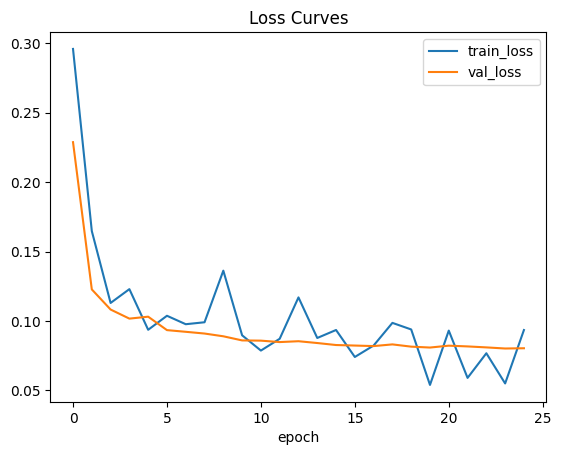

In [68]:
loss_curves = loss_curves.groupby("epoch").mean().reset_index(inplace=False)
loss_curves.plot(x="epoch", y=["train_loss", "val_loss"], title="Loss Curves")

In [69]:
pos_mask = (y == 1)
pos_probas = probas[pos_mask]
y_pos = y[pos_mask]
neg_probas = probas[~pos_mask]

In [70]:
for pr, tr in zip(pos_probas, y_pos):
    print(f"Predicted: {pr}, True: {tr}")

Predicted: 0.7660044431686401, True: 1.0
Predicted: 0.1691242903470993, True: 1.0
Predicted: 0.7869940996170044, True: 1.0
Predicted: 0.9255423545837402, True: 1.0
Predicted: 0.578230082988739, True: 1.0
Predicted: 0.7399061918258667, True: 1.0
Predicted: 0.9971656203269958, True: 1.0
Predicted: 0.9997925162315369, True: 1.0
Predicted: 0.32815876603126526, True: 1.0
Predicted: 0.9943305253982544, True: 1.0
Predicted: 0.9806666970252991, True: 1.0
Predicted: 0.9186988472938538, True: 1.0
Predicted: 0.9989257454872131, True: 1.0
Predicted: 0.9976372718811035, True: 1.0
Predicted: 0.9969243407249451, True: 1.0
Predicted: 0.5467751622200012, True: 1.0
Predicted: 0.34201475977897644, True: 1.0
Predicted: 0.2592606246471405, True: 1.0
Predicted: 0.9948675632476807, True: 1.0
Predicted: 0.9978694915771484, True: 1.0
Predicted: 0.9930287003517151, True: 1.0
Predicted: 0.9977909326553345, True: 1.0
Predicted: 0.9999023675918579, True: 1.0
Predicted: 0.969829261302948, True: 1.0
Predicted: 0.998

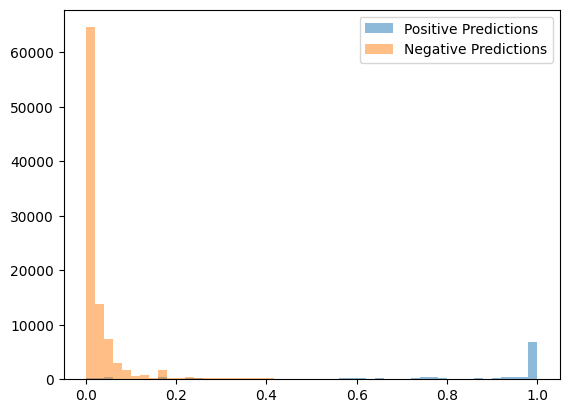

In [71]:
plt.hist(pos_probas, bins=50, alpha=0.5, label="Positive Predictions")
plt.hist(neg_probas, bins=50, alpha=0.5, label="Negative Predictions")
plt.legend()
plt.show()

Precision: 0.9198182113293296, Recall: 0.7864825480535702, Accuracy: 0.9639272688549902


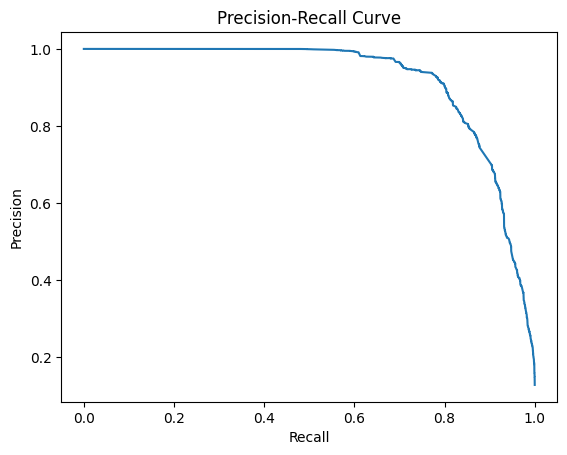

In [74]:
dt = 0.5

y_pred = (probas > dt).astype(int)
precision = precision_score(y, y_pred)
accuracy_score = accuracy_score(y, y_pred)
recall = recall_score(y, y_pred)
print(f"Precision: {precision}, Recall: {recall}, Accuracy: {accuracy_score}")
precision, recall, thresholds = precision_recall_curve(y, probas)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

Rxn-rule joint splitting

In [10]:
len(df['rule_id'].unique()), len(df["rxn_id"].unique()), len(df), len(df["smarts"].unique())

(454, 8139, 8139, 8139)

In [8]:
rule_clusters = [set(df.loc[df["rule_id"] == id, "rxn_id"]) for id in df["rule_id"].unique()]